This `python3` notebook reproduces the results described in [this paper](https://academic.oup.com/mnras/advance-article-abstract/doi/10.1093/mnras/staa3595/5999079?redirectedFrom=fulltext) and updated in this [RNAAS post](https://iopscience.iop.org/article/10.3847/2515-5172/abd189/meta) 

In [1]:
#Load libraries
import os
import numpy as np
import pandas as pd
import json, requests

from astropy import units as u
from astropy import constants as c 
from astropy.units import Quantity
from astroquery.gaia import Gaia

from astropy.io.votable import parse
from astropy.table import Table,Column, unique
from astropy.coordinates import SphericalRepresentation,UnitSphericalDifferential, Angle,SkyCoord
import astropy.coordinates as coord

from astropy.time import Time

from astropy.table import unique as unique_table
from astroquery.xmatch import XMatch

import matplotlib.pyplot as plt 
from matplotlib import colors

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


Duplicate key in file '/Users/janton/.matplotlib/matplotlibrc' line #489.


Could not import regions, which is required for some of the functionalities of this module.


In [2]:
#Global variables 

#Columns displayed when the results are printed on screen 
columns = ['name','TrueAngDist','poserror','parallax','parallax_error', 'px', 'pxerr','pmra','pmdec','pmra_radio' ,'pmdec_radio','p0','pb','dm','phot_g_mean_mag','Pass']

#This  value added in quadrature to the positional error, to acount for systematics. 
#0".25 seems to be a reasonable value; see paper for details
systematic_position_error = Quantity(0.25,u.arcsec)

In [80]:
#Define some useful functions

def random_power_law(a, b, p, size=1):
    '''
    Power-law gen for pdf(x)\propto x^{p} for a<=x<=b   
    
    Parameters
    ----------
    a    : float 
        lower boundary of the output interval
    b    : float 
        upper boundary of the output interval
    p    : float 
        exponent of the power-law distribution
    size : int 
        number of samples    
    
    Returns
    ----------
    out  : array or float 
        Drawn samples from power-law distribution  
    '''
    g = p+1
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)


def find_nearest(array, value):
    '''
    returns the element of the array that is nearest to value   
    
    Parameters
    ----------
    array  : numpy array 
    value  : float 
   
    Returns
    ----------
    out    : float 
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def find_nearest_idx(array, value):
    '''
    returns the index of the array element that is nearest to value  
    
    
    Parameters
    ----------
    array  : numpy array 
    value  : float 
   
    Returns
    ----------
    out    : int 
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def absolute_magnitude(mass):
    """
    Magnitude / mass relation for MS stars, 
    taken from Table 6 in 
    https://academic.oup.com/mnras/article/382/3/1073/1008562 """
    logm = np.log10(mass)
    return 4.85 - 14.2*logm + 14.1*logm**2 - 9.99*logm**3 + 2.66*logm**4


def mdot_given_mass(mass,e=0.5,v=1000*u.km/u.s):
    '''
    Scaling relation for mass loss as a function of mass for MS stars
    
    '''
    L = 19*mass**(2.76)*u.Lsun
    Mdot = e*L/(v*c.c)
    return Mdot.to(u.Msun/u.yr)

def minimum_period_for_radio_detection(mdot,mtot,Teff=1e4,ecc=0.):
    '''
    Calculates the minimum orbital period for which 1.4 GHz 
    radiation is not obscured by free-free absorbtion
    
    see Illarionov & Sunyaev 1975 
    '''
    return ((1+ecc)**(-3./2.) * 0.28*(mdot/4.8e-12)/mtot * u.day).to(u.yr)


def send_radial_gaia_query(query_size=1000, distance=200, **kwargs):
    """
    This was used for making the HR and RPM diagrams and was taken directly from here:
    https://vlas.dev/post/gaia-dr2-hrd/
    
    
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """

    job = Gaia.launch_job_async("select top {}".format(query_size)+
                " lum_val, teff_val,"
                " ra, dec, parallax,"
                " bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg,"
                "pmra, pmdec,phot_g_mean_mag"
         " from gaiadr2.gaia_source"
         " where parallax_over_error > 4"
         " and visibility_periods_used > 8"
         " and phot_g_mean_flux_over_error > 50"
         " and phot_bp_mean_flux_over_error > 20"
         " and phot_rp_mean_flux_over_error > 20"
         " and phot_bp_rp_excess_factor <"
            " 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and phot_bp_rp_excess_factor >"
            " 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
         " and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<"
            "1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
         +" and 1000/parallax <= {}".format(distance), **kwargs)

    return job



def get_reddening(lon, lat, coordsys='equ', mode='full',rv=3.1):
    '''
    Taken from http://argonaut.skymaps.info/usage
    
    Send a line-of-sight reddening query to the Argonaut web server.

    Inputs:
      lon, lat: longitude and latitude, in degrees.
      coordsys: 'gal' for Galactic, 'equ' for Equatorial (J2000).
      mode: 'full', 'lite' or 'sfd'

    In 'full' mode, outputs a dictionary containing, among other things:
      'distmod':    The distance moduli that define the distance bins.
      'best':       The best-fit (maximum proability density)
                    line-of-sight reddening, in units of SFD-equivalent
                    E(B-V), to each distance modulus in 'distmod.' See
                    Schlafly & Finkbeiner (2011) for a definition of the
                    reddening vector (use R_V = 3.1).
      'samples':    Samples of the line-of-sight reddening, drawn from
                    the probability density on reddening profiles.
      'success':    1 if the query succeeded, and 0 otherwise.
      'converged':  1 if the line-of-sight reddening fit converged, and
                    0 otherwise.
      'n_stars':    # of stars used to fit the line-of-sight reddening.
      'DM_reliable_min':  Minimum reliable distance modulus in pixel.
      'DM_reliable_max':  Maximum reliable distance modulus in pixel.

    Less information is returned in 'lite' mode, while in 'sfd' mode,
    the Schlegel, Finkbeiner & Davis (1998) E(B-V) is returned.
    '''

    url = 'http://argonaut.skymaps.info/gal-lb-query-light'

    payload = {'mode': mode}

    if coordsys.lower() in ['gal', 'g']:
        payload['l'] = lon
        payload['b'] = lat
    elif coordsys.lower() in ['equ', 'e']:
        payload['ra'] = lon
        payload['dec'] = lat
    else:
        raise ValueError("coordsys '{0}' not understood.".format(coordsys))

    headers = {'content-type': 'application/json'}

    r = requests.post(url, data=json.dumps(payload), headers=headers)

    try:
        r.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print('Response received from Argonaut:')
        print(r.text)
        raise e

    return json.loads(r.text)


def extinction_to_pulsars(pulsars):
    '''
    Returns the extinction vs distance_mod towards the direction 
    of the objects in the astropy.Table generated by the main script below
    '''
    extinctions =[]
    for pulsar in pulsars:
        reddening=get_reddening(pulsar['ra'],pulsar['dec'],mode='lite')
        if reddening['converged']:
            extinctions.append(reddening)
        else:
            reddening=get_reddening(pulsar['ra'],pulsar['dec'],mode='sfd')
            extinctions.append(reddening)
    return extinctions

def distance_from_px(px,sigma_px,dm_dist=None):
    '''
    Infer distance from parallax (see paper for details)
    '''
    d = np.arange(0.001,35.,0.001)
    p = np.exp(-(1/d-px)**2/(2*sigma_px**2.))
    p=p/p.sum()

    p_corrected = (1./(2*1.35**3))*d**2 * np.exp(-d/1.35) * np.exp(-(1/d-px)**2/(2*sigma_px**2.))
    p_corrected = p_corrected/p_corrected.sum()
    if dm_dist:
        p_dm = np.exp(-(d-dm_dist)**2/(2*(dm_dist*0.4)**2.))
        p_dm = p_dm/p_dm.sum()
        p_dm = p_corrected*p_dm
        p_dm = p_dm/p_dm.sum()
        d_mean = d[np.abs(p_dm.cumsum()-0.5).argmin()]
        dlow = d[np.abs(p_dm.cumsum()-0.05).argmin()]
        dhigh= d[np.abs(p_dm.cumsum()-0.95).argmin()]
    else:
        p_dm =0
        d_mean = d[np.abs(p_corrected.cumsum()-0.5).argmin()]
        dlow = d[np.abs(p_corrected.cumsum()-0.05).argmin()]
        dhigh= d[np.abs(p_corrected.cumsum()-0.95).argmin()]


    return np.array([d_mean,dlow,dhigh]),d,p,p_corrected,p_dm



def distance_to_pulsar(pulsar):
    '''
    Calculate distance to a pulsar
    '''
    if (pulsar['TypeRef'] == 'EXGAL:LMC') or  (pulsar['TypeRef'] == 'EXGAL:LMC,SNR:0540-693'):
        d_mean = 62.1
        dlow = 62.1-1.9
        dhigh=62.1+1.9
        distance = np.array([d_mean,dlow,dhigh])
        d = None
        p = None
        p_corrected = None
        p_dm = None

    elif pulsar['TypeRef'] == 'EXGAL:SMC':
        d_mean = 49.97
        dlow = 49.97-1.13
        dhigh=49.97+1.13
        distance = np.array([d_mean,dlow,dhigh])
        d = None
        p = None
        p_corrected = None
        p_dm = None

    elif (pulsar['pb']>0) & (pulsar['pb']<1e+20):
        if (pulsar['px']/pulsar['pxerr']>=3) & (pulsar['px']/pulsar['pxerr']<=1000):
            distance,d,p,p_corrected,p_dm = distance_from_px(pulsar['px'],pulsar['pxerr'],dm_dist=None)
        elif (pulsar['parallax']/pulsar['parallax_error']>=3) & (pulsar['parallax']/pulsar['parallax_error']<=1000):
            distance,d,p,p_corrected,p_dm = distance_from_px(pulsar['parallax'],pulsar['parallax_error'],dm_dist=None)
        elif (pulsar['parallax']/pulsar['parallax_error']<=3) & (pulsar['parallax']<1e3):
            distance,d,p,p_corrected,p_dm = distance_from_px(pulsar['parallax'],pulsar['parallax_error'],dm_dist=pulsar['dist'])
        elif (pulsar['px']/pulsar['pxerr']<=3) & (pulsar['px']<1e3):
            distance,d,p,p_corrected,p_dm = distance_from_px(pulsar['parallax'],pulsar['parallax_error'],dm_dist=pulsar['dist'])
        else:
            d_mean = pulsar['dist']
            dlow = d_mean - 0.2*d_mean
            dhigh = d_mean + 0.2*d_mean
            distance = np.array([d_mean,dlow,dhigh])
            d = None
            p = None
            p_corrected = None
            p_dm = None
    else:
        if (pulsar['parallax']/pulsar['parallax_error']>=3) & (pulsar['parallax']/pulsar['parallax_error']<=1000):
            distance,d,p,p_corrected,p_dm = distance_from_px(pulsar['parallax'],pulsar['parallax_error'],dm_dist=None)
        elif (pulsar['parallax']/pulsar['parallax_error']<=3) & (pulsar['parallax']<1e3):
            distance,d,p,p_corrected,p_dm = distance_from_px(pulsar['parallax'],pulsar['parallax_error'],dm_dist=None)
        else:
            d_mean = pulsar['dist']
            dlow = d_mean - 0.2*d_mean
            dhigh = d_mean + 0.2*d_mean
            distance = np.array([d_mean,dlow,dhigh])
            d = None
            p = None
            p_corrected = None
            p_dm = None
    return distance,d,p,p_corrected,p_dm


def update_positions(ra,
                      dec,
                      pmra,
                      pmdec,
                      epoch1,
                      epoch2,
                      sigma_ra=None,
                      sigma_dec=None,
                      sigma_pmra=None,
                      sigma_pmdec=None,
                      distance = None,
                      systematic = Quantity(0.25,u.arcsec/u.yr)):
    '''
    Propagates the astrometric coordinates and their uncertainties from the reference epoch (epoch1)
    to epoch2 
    This is done using astropy's UnitSphericalDifferential and generally requires the distance to be known.
    If the distance is not given it defaults to 1 kpc. 
    '''
    
    ra = Quantity(ra,u.deg)
    dec = Quantity(dec,u.deg)
    pmra = Quantity(pmra,u.mas/u.yr)
    pmdec = Quantity(pmdec,u.mas/u.yr)
    if sigma_ra:
        sigma_ra = Quantity(sigma_ra,u.mas)
        sigma_dec = Quantity(sigma_dec,u.mas)
        sigma_pmra = Quantity(sigma_pmra,u.mas/u.yr)
        sigma_pmdec = Quantity(sigma_pmdec,u.mas/u.yr)
        no_measurement = np.where(pmra == 0)
        sigma_pmra[no_measurement] = systematic
        sigma_pmdec[no_measurement] = systematic

    if not distance:
        distance = 1*u.kpc 

    #as per the astropy docs example. Distance is needed to evaluate cross-products 
    coords=SphericalRepresentation(ra,dec,distance) 

    pm = UnitSphericalDifferential(pmra, pmdec)
    new_coords = coords + pm*(epoch2-epoch1)



    if (sigma_ra != None) and (sigma_pmra != None):
        sigma_ra = sigma_ra**2 + (np.abs((epoch2.mjd*u.day - epoch1.mjd*u.day))*sigma_pmra)**2
        sigma_ra = sigma_ra**0.5
    else:
        sigma_ra = Quantity(99,u.mas)
    if (sigma_dec != None) and (sigma_pmdec != None):
        sigma_dec = sigma_dec**2 + (np.abs((epoch2.mjd*u.day - epoch1.mjd*u.day))*sigma_pmdec)**2
        sigma_dec = sigma_dec**0.5
    else:
        sigma_dec = Quantity(99,u.mas)
   
    return new_coords.lon.to(u.deg),new_coords.lat.to(u.deg),sigma_ra.to(u.mas),sigma_dec.to(u.mas)


def update_psrcat(psrcat_file='pulsars.txt',epoch=None,updated_cat='updated_pulsar_params.txt',extrapolate=False):
    """
    reads in a prcat table and propagates the positions to epoch
    """

    if not epoch:
        epoch = Time('J2000')

    pulsars = pd.read_table('pulsars.txt',delimiter='\s+',na_values='*',
                            names=['id','name','nref',
                                   'raj', 'rajerr', 'raref' ,
                                   'decj','decjerr', 'dref',
                                   'pmra_radio','pmraerr', 'prref',
                                   'pmdec_radio','pmdecerr', 'pdref',
                                   'px','pxerr','pxref', 
                                   'posepoch', 'poseref',
                                   'p0','p0err','p0ref',
                                   'p1','p1err', 'p1ref', 
                                   'dm','dmerr', 'dmref',
                                   'dist',
                                   'pb','pberr', 'pbref',
                                   'survey','surveyref','BinComp',
                                   'BinCompref','Type','TypeRef', 'Assoc'])
    pulsars = Table.from_pandas(pulsars)[7:]
    pulsars['raj']=Angle(pulsars['raj'],u.hourangle).to(u.deg)
    pulsars['rajerr']=Angle(pulsars['rajerr'],u.arcsec)
    pulsars['decj'] = Angle(pulsars['decj'], u.deg)
    pulsars['decjerr']=Angle(pulsars['rajerr'],u.arcsec)
    pulsars['pmra_radio'] = np.nan_to_num(pulsars['pmra_radio']*u.mas/u.yr)
    pulsars['pmdec_radio'] = np.nan_to_num(pulsars['pmdec_radio']*u.mas/u.yr)

    i=0
    posepochs = []
    for p in pulsars['posepoch']:
        posepochs.append(np.float(p))
        i+=1
    posepochs = np.nan_to_num(posepochs,45000.0)  #update missing posepochs to J2000? 

    pulsars['posepoch'] = Time(posepochs,format='mjd',scale='tdb')
    pulsars['raj_now'],pulsars['decj_now'],_,_ = update_positions(pulsars['raj'],
                                                               pulsars['decj'],
                                                               pulsars['pmra_radio'],
                                                               pulsars['pmdec_radio'],
                                                               pulsars['posepoch'],epoch)



    pulsars.write(updated_cat,format='csv',overwrite=True)
    return pulsars



Now we have everything we need to run a cross search between Gaia and ATNF. Note that the following function uses the psrcat command-line tools to fetch data from the ATNF database. For installation instructions see:
https://www.atnf.csiro.au/research/pulsar/psrcat/download.html

Alternatively, one can also calculate the data manually from here:
https://www.atnf.csiro.au/research/pulsar/psrcat/


In [23]:
def run_search():
    j2000_epoch = Time('J2000') #we use J2000 positions as ViZier XMAtch defaults to these
    gaia_epoch = Time('J2000.0') 
    #gaia_epoch = Time('J2016.0') #
    
    # radius of the initial query. 
    search_radius = 20.0*u.arcsec  


    os.system(
        "psrcat -c \"name raj decj pmra pmdec px posepoch p0 p1 dm dist pb survey BinComp Type Assoc\" -o long_error -nohead -l \"error(raj)>0\"> pulsars.txt")

    #propagate pulsar positions. For J2000 this just reads in the table we just downloaded 
    psrcatnew=update_psrcat(epoch=j2000_epoch)


    #This can also be done with astroquery, as below. However, this currently doesn't seem to work with eDR3, 
    # see https://github.com/astropy/astroquery/issues/1912
    os.system(
        "curl -X POST -F request=xmatch -F distMaxArcsec=20.0 -F RESPONSEFORMAT=csv -F cat1=@updated_pulsar_params.txt -F colRA1=raj -F colDec1=decj -F cat2=vizier:I/350/gaiaedr3 http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync > pulsar_results.csv")
    gaia_cross_matches = Table.read('pulsar_results.csv',format='csv')


    #gaia_cross_matches = XMatch.query(
    #    cat1=open('updated_pulsar_params.txt'),
    #    cat2='vizier:I/350/gaiaedr3', max_distance=search_radius, 
    #    colRA1='raj', colDec1='decj',colRA2='ra_epoch2000',colDec2='dec_epoch2000') 


    posepoch = Time(gaia_cross_matches['posepoch'],format='mjd',scale='tdb')

    #Directly inverting the parallax is not recommended but it's good enough for propagating ra,dec positions 
    distance = Quantity(1/np.nan_to_num(gaia_cross_matches['parallax']),u.kpc)
    
    #This is not optimal, nor as fast as it can be, but it works and is more reliable than the above. 
    #distance = np.ones_like(posepoch)
    #j=0
    #for source in gaia_cross_matches:
    #    try:
    #        d,_,_,_,_ = distance_from_px(np.nan_to_num(source['parallax']),np.nan_to_num(source['parallax_error'])) 
    #    except:
    #        pass
    #    distance[j] = d[0]
    #    j = + 1
    #distance = distance*u.kpc

    filtdist = np.where(np.nan_to_num(gaia_cross_matches['parallax'])/np.nan_to_num(gaia_cross_matches['parallax_error'])<3)
    distance[filtdist] = 1*u.kpc 

    raj = Quantity(np.nan_to_num(gaia_cross_matches['raj']),u.deg)
    decj = Quantity(np.nan_to_num(gaia_cross_matches['decj']),u.deg)
    rajerr= Quantity(gaia_cross_matches['rajerr'],u.arcsec)
    decjerr = Quantity(gaia_cross_matches['decjerr'],u.arcsec)


    pmra = Quantity(np.nan_to_num(gaia_cross_matches['pmra']),u.mas/u.yr)
    pmdec = Quantity(np.nan_to_num(gaia_cross_matches['pmdec']),u.mas/u.yr)
    pmra_error = Quantity(np.nan_to_num(gaia_cross_matches['pmra_error']),u.mas/u.yr)
    pmdec_error = Quantity(np.nan_to_num(gaia_cross_matches['pmdec_error']),u.mas/u.yr)



    ra_error = Quantity(gaia_cross_matches['ra_error'],u.mas)
    dec_error = Quantity(gaia_cross_matches['dec_error'],u.mas)
    ra = Quantity(np.nan_to_num(gaia_cross_matches['ra']),u.deg)
    dec = Quantity(np.nan_to_num(gaia_cross_matches['dec']),u.deg)
    ra_epoch2000 = Quantity(np.nan_to_num(gaia_cross_matches['ra_epoch2000']),u.deg)
    dec_epoch2000 = Quantity(np.nan_to_num(gaia_cross_matches['dec_epoch2000']),u.deg)


    ra_gaia_psrep, dec_gaia_psrep, sigma_ra_gaia,sigma_dec_gaia = update_positions(ra_epoch2000,
                                                                                    dec_epoch2000,
                                                                                    pmra,
                                                                                    pmdec,
                                                                                    gaia_epoch,
                                                                                    posepoch,
                                                                                    ra_error,
                                                                                    dec_error,
                                                                                    pmra_error,
                                                                                    pmdec_error,
                                                                                    distance)

    c_gaia = SkyCoord(ra_gaia_psrep, dec_gaia_psrep,frame='icrs')
    c_psr = SkyCoord(raj, decj,frame='icrs') #not all psrcat positions are icrs, but let's ignore that for now                                                                                   
    TrueAngDist = c_gaia.separation(c_psr).to(u.arcsec)
    poserror    = (rajerr**2 + decjerr**2 + sigma_ra_gaia**2 + sigma_dec_gaia**2 + 
                   systematic_position_error**2)**0.5

    gaia_cross_matches['poserror'] = poserror.to(u.arcsec)
    gaia_cross_matches['TrueAngDist'] = TrueAngDist 

    gaia_cross_matches['ra_gaia_psrep'] = ra_gaia_psrep 
    gaia_cross_matches['dec_gaia_psrep'] = dec_gaia_psrep 
    gaia_cross_matches['sigma_ra_gaia'] = sigma_ra_gaia
    gaia_cross_matches['sigma_dec_gaia'] = sigma_dec_gaia

    gaia_cross_matches['Associated'] = (((TrueAngDist < 2.0*poserror) & (poserror.value < 0.5))) 

    Pass = np.zeros(len(gaia_cross_matches))
    associated = np.where(gaia_cross_matches['Associated'])

    for i in associated[0]:
        name =  gaia_cross_matches['name'][i]
        poserror = gaia_cross_matches['poserror'][i]
        Table(gaia_cross_matches['id','raj','decj'][i]).write('temp.vot',format='votable',overwrite=True)
        try:
            neighbours = XMatch.query(cat1=open('temp.vot'),cat2='vizier:I/345/gaia2', max_distance=2 * u.arcmin,  colRA1='raj', colDec1='decj')
            density = float(len(neighbours)) / (np.pi*(2*u.arcmin)**2.)
        except:
            density = 1e6 * (1/u.arcsec**2)
        prob_chance = 1 - np.exp(-np.pi*(density.to(1/u.arcsec**2).value)*(3*poserror)**2)
        prob_loc = np.exp(-TrueAngDist[i].value**2/(2*poserror**2))
        Pass[i] = 1-prob_chance



    Pass = Column(Pass,name='Pass')
    gaia_cross_matches.add_column(Pass)  

    binaries = np.where(((gaia_cross_matches['pb'] > 0.0) & (gaia_cross_matches['Associated']==True)))
    slow = np.where((gaia_cross_matches['Associated']==True) & (gaia_cross_matches['p0']>0.035))

      
    gaia_cross_matches[slow][columns].pprint(max_lines=-1)
    gaia_cross_matches[binaries][columns].pprint(max_lines=-1)
    print("Slow pulsars:", len(gaia_cross_matches[slow]))
    print("known binary pulsars:", len(gaia_cross_matches[binaries]))
    gaia_cross_matches[slow].write('slow_psrs.csv',format='csv',overwrite=True)
    gaia_cross_matches[binaries].write('binaries_psrs.csv',format='csv',overwrite=True)
    return gaia_cross_matches.filled(), slow, binaries

def make_catalogue():
    '''
    This will create the final catalogue 
    '''
    pulsars,slow,binaries=run_search()

    #known counterparts 
    names = ['J0045-7319','J2129-0429']

    for name in names:
        filt = np.where(pulsars['name'] == name)
        pulsars[filt[0][0]]['Pass'] = 1.0
        pulsars[filt[0][0]]['Assoc'] = True

    columns = ['angDist','id',
               'name','raj','rajerr',
               'decj','TypeRef','decjerr',
               'pmra_radio','pmraerr',
               'pmdec_radio','pmdecerr',
               'px','pxerr','posepoch','p0',
               'p0err','p1','p1err',
               'dm','dmerr','dist','pb',
               'pberr','survey','Assoc',
               'raj_now','decj_now',
               'ra_epoch2000','dec_epoch2000',
               'source_id','ra','ra_error',
               'dec','dec_error','parallax','parallax_error',
               'pm','pmra','pmra_error',
               'pmdec','pmdec_error','phot_g_mean_mag',
               'phot_bp_mean_mag','phot_rp_mean_flux',
               'phot_rp_mean_mag','bp_rp',
               'phot_g_mean_mag_error','phot_bp_mean_mag_error',
               'phot_rp_mean_mag_error','poserror',
               'TrueAngDist','ra_gaia_psrep',
               'dec_gaia_psrep','sigma_ra_gaia','sigma_dec_gaia',
               'Associated','Pass']
    pulsars = pulsars[columns]
    pulsars['g_abs'] = 99.
#    pulsars['g_abs_min'] = 99.
#    pulsars['g_abs_max'] = 99.
    pulsars['b_r_abs'] = 99.
#    pulsars['b_r_abs_min'] = 99.
#    pulsars['b_r_abs_max'] = 99.
    pulsars['distance'] = 99.
    pulsars['distance_min'] = 99.
    pulsars['distance_max'] = 99.
    pulsars['dust'] = 99.
    pulsars['dust_min'] = 99.
    pulsars['dust_max'] = 99.


    pulsars['poserror_sys'] = pulsars['poserror']
    pulsars['poserror'] = (pulsars['poserror_sys']**2. - 0.25**2.)**0.5
    
    
    associated = np.where((pulsars['Pass']>0.0))
    extinction=extinction_to_pulsars(pulsars[associated])
    i=0
    for a in associated[0]:
        distance,_,_,_,_=distance_to_pulsar(pulsars[a])
        pulsars[a]['distance'] = distance[0]
        pulsars[a]['distance_min'] = distance[1]
        pulsars[a]['distance_max'] = distance[2]
        

        dist_mod = 5*np.log10(1000.*distance[0])-5.
        dist_mod_min = 5*np.log10(1000.*distance[1])-5.
        dist_mod_max = 5*np.log10(1000.*distance[2])-5.

        try:
             pulsars[a]['dust'] = np.interp(dist_mod,extinction[i]['distmod'],extinction[i]['best'])*3.1
             pulsars[a]['dust_min'] = np.interp(dist_mod_min,extinction[i]['distmod'],extinction[i]['best'])*3.1
             pulsars[a]['dust_max'] = np.interp(dist_mod_max,extinction[i]['distmod'],extinction[i]['best'])*3.1
        except:
            if distance[0]<=8.:
                pulsars[a]['dust'] = extinction[i]['EBV_SFD']*3.1*(distance[0]/8.)
                pulsars[a]['dust_min'] = extinction[i]['EBV_SFD']*3.1*(distance[1]/8.)
                pulsars[a]['dust_max'] = extinction[i]['EBV_SFD']*3.1*(distance[2]/8.)
            else:
                pulsars[a]['dust'] = extinction[i]['EBV_SFD']*3.1*np.ones_like(distance[0])
                pulsars[a]['dust_min'] = extinction[i]['EBV_SFD']*3.1*np.ones_like(distance[0])
                pulsars[a]['dust_max'] = extinction[i]['EBV_SFD']*3.1*np.ones_like(distance[0])
        
        pulsars[a]['g_abs'] =  pulsars[a]['phot_g_mean_mag'] -dist_mod - pulsars[a]['dust']
        pulsars[a]['b_r_abs'] =  pulsars[a]['bp_rp'] - pulsars[a]['dust']/3.1


        i = i+1  

    pulsars.write('gaia_atnf_ant2021.fits',format='fits',overwrite=True)
    return pulsars

In [24]:
pulsars,_,_ = run_search()
make_catalogue()


/Users/janton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:386: UserWarning: Warning: converting a masked element to nan.


   name         TrueAngDist      ... phot_g_mean_mag        Pass       
                   arcsec        ...                                   
---------- --------------------- ... --------------- ------------------
J0045-7319    0.5042564656354669 ...       16.198153 0.8695229302925443
J0348+0432 0.0020550339284305537 ...       20.589453 0.9994498886789058
J0534-6703    0.5187272421648461 ...       18.860022 0.9436421594986573
  B0540-69   0.02788995549523586 ...       20.768072 0.9327302499041886
J1322-6329    0.6293769126644438 ...       20.598015  0.760092456113034
J1509-6015   0.19994290218426347 ...       17.760696 0.9100495112600006
J1529-5355    0.6012852130330477 ...       16.939287 0.8769957534926831
  B1259-63  0.059663918929261324 ...        9.632835 0.9625911703424204
J1624-4411   0.29313751017586365 ...       19.884068 0.9532487617178454
J1624-4721    0.3088669636523188 ...       20.391033 0.9248487501021722
J1614-5402    0.2810588217241514 ...       20.780014 0.849304285

B0531+21
J0534-6703
B0540-69
J0045-7319
J0337+1715
J0348+0432
J0437-4715
J0514-4002A
J1012+5307
J1023+0038
J1024-0719
J1048+2339
J0024-7204U
J1227-4853
J1417-4402
B1259-63
J1311-3430
J1322-6329
J1529-5355
J1509-6015
J1431-4715
J1435-6100
J1437-6146
J1542-5133
J1546-5302
J1624-4411
J1624-4721
J1614-5402
J1638-4608
J1723-2837
J1740-5340A
J1735-3258
J1727-2739
J1750-3703D
J1808-3249
J1810+1744
J1838-0549
J1816+4510
B1848+12
J1852+0040
J1903-0258
J1910-5959D
J2215+5135
J2339-0533
B1953+29
J1957+2516
J1958+2846
B1957+20
J2027+4557
J2032+4127
J2129-0429


/Users/janton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:261: RuntimeWarning: divide by zero encountered in double_scalars
/Users/janton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:267: RuntimeWarning: divide by zero encountered in double_scalars


angDist,id,name,raj,rajerr,decj,TypeRef,decjerr,pmra_radio,pmraerr,pmdec_radio,pmdecerr,px,pxerr,posepoch,p0,p0err,p1,p1err,dm,dmerr,dist,pb,pberr,survey,Assoc,raj_now,decj_now,ra_epoch2000,dec_epoch2000,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_mag,bp_rp,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,poserror,TrueAngDist,ra_gaia_psrep,dec_gaia_psrep,sigma_ra_gaia,sigma_dec_gaia,Associated,Pass,g_abs,b_r_abs,distance,distance_min,distance_max,dust,dust_min,dust_max,poserror_sys
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,deg,deg,mas,mas,,,,,,,,,,,arcsec
float64,int64,str12,float64,float64,float64,str86,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str48,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.164581,8,J0024-7204ab,6.034006249999999,0.0005,-72.07988944444445,GC:47Tuc,0.0005,4.2,0.6,-2.9,0.5,1e+20,0.0,51600.0,0.0037046394947985,6e-16,9.82e-21,9e-24,24.37,0.02,2.54,1e+20,0.0,misc,999999,6.034006072724162,-72.0798893220397,6.03494384766,-72.07905908352,4689639266845494400,6.03502627562,0.1113,-72.07907011793,0.1324,0.5424,0.1255,6.223,5.707,0.133,-2.483,0.156,11.791112,11.440872,765524.0,10.037998,1.402874,0.006331,0.025721,0.01821,0.0007286204540742277,3.1643123573721916,6.034944088544099,-72.07905918832377,0.11311989962363736,0.1345052207642694,False,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.25000106177327747
3.171438,8,J0024-7204ab,6.034006249999999,0.0005,-72.07988944444445,GC:47Tuc,0.0005,4.2,0.6,-2.9,0.5,1e+20,0.0,51600.0,0.0037046394947985,6e-16,9.82e-21,9e-24,24.37,0.02,2.54,1e+20,0.0,misc,999999,6.034006072724162,-72.0798893220397,6.03473628909,-72.08074128183,4689639266844729088,6.03480432775,0.068,-72.08075423941,0.0837,0.438,0.0805,5.539,4.71,0.077,-2.915,0.109,11.21692,11.626557,776641.0,10.022345,1.604213,0.003393,0.010617,0.005431,0.0007155703358032071,3.171922066510889,6.034736487892191,-72.08074140486788,0.06899923771296532,0.08532297848423659,False,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.2500010240797135
3.822083,8,J0024-7204ab,6.034006249999999,0.0005,-72.07988944444445,GC:47Tuc,0.0005,4.2,0.6,-2.9,0.5,1e+20,0.0,51600.0,0.0037046394947985,6e-16,9.82e-21,9e-24,24.37,0.02,2.54,1e+20,0.0,misc,999999,6.034006072724162,-72.0798893220397,6.03415913773,-72.07882879736,4689639266835395584,6.0342742357,0.1863,-72.07881930305,0.2874,-0.0304,0.2219,8.25,7.969,0.378,2.136,0.623,12.025392,11.392838,763795.0,10.040453,1.352385,0.007259,0.005902,0.017637,0.0007934525948536194,3.822424213439142,6.034159474089798,-72.07882870720258,0.19495317813152385,0.3025892902870885,False,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.25000125913086974
3.870162,8,J0024-7204ab,6.034006249999999,0.0005,-72.07988944444445,GC:47Tuc,0.0005,4.2,0.6,-2.9,0.5,1e+20,0.0,51600.0,0.0037046394947985,6e-16,9.82e-21,9e-24,24.37,0.02,2.54,1e+20,0.0,misc,999999,6.034006072724162,-72.0798893220397,6.03717248868,-72.07943492241,4689639266845494528,6.03717248868,0.4625,-72.07943492241,1.2837,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,13.799373,1e+20,1e+20,1e+20,1e+20,0.012529,1e+20,1e+20,0.053744668624735134,3.8701621770819776,6.03717248868,-72.07943492241,37.99049503588096,38.00936322159707,False,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.25571173106758827
4.585193,8,J0024-7204ab,6.034006249999999,0.0005,-72.07988944444445,GC:47Tuc,0.0005,4.2,0.6,-2.9,0.5,1e+20,0.0,51600.0,0.0037046394947985,6e-16,9.82e-21,9e-24,24.37,0.02,2.54,1e+20,0.0,misc,999999,6.034006072724162,-72.0798893220397,6.02999053569,-72.07958042196,468

The following function estimates the binary fraction given a list of (non)detections 

In [40]:
def binary_fraction(pulsars=None,N=1000,extinctions=None,log_period_thres=3.5622,mag_thres=20.5,min_mass=1.,radio_ab=False,massive=False):

    if pulsars is None:
        pulsars,slow,binaries = run_search()
        #remove GC pulsars 
        i=0
        to_remove = []
        for i in range(len(pulsars)):
            if any(c.isalpha() for c in pulsars[i]['name'][1:]):
                #print(pulsars[i]['name'][1:],i)
                to_remove.append(i)
        
            i=i+1
        pulsars.remove_rows(to_remove)
        exgal = np.where((pulsars['TypeRef']=='EXGAL:SMC') | (pulsars['TypeRef']=='EXGAL:LMC'))
        pulsars.remove_rows(exgal)


            #remove duplicates and select slow pulsars
        pulsars=unique_table(pulsars,keys='name')
        pulsars['B']=3.2*1e19* (pulsars['p0']*pulsars['p1'])**0.5
    slow_pulsars=pulsars[(pulsars['B']>1e10) & (pulsars['B']<1e20) & (pulsars['dm']<1e20) & (pulsars['poserror']<0.5)]





    #get extinction curves 
    if extinctions is None:
        extinctions = extinction_to_pulsars(slow_pulsars)



    n_pulsars = len(slow_pulsars)
    HasCompanion = np.zeros([n_pulsars,N])
    Vapp_mag =  np.zeros([n_pulsars,N]) - 99.
    Rv =  np.zeros([n_pulsars,N])
    mass =  np.zeros([n_pulsars,N])
    period = np.zeros([n_pulsars,N])
    separation = np.zeros([n_pulsars,N])
    inclination = np.zeros([n_pulsars,N])
    dist_mod = np.zeros([n_pulsars,N])
    is_detected = np.zeros([n_pulsars,N])

    catalogued = np.zeros([n_pulsars,N])

    for i in range(n_pulsars):
        pulsar = slow_pulsars[i]
    #    print(pulsar['name'])
        
        distance=np.random.normal(pulsar['dist'],pulsar['dist']*0.2,N)
        dist_mod[i,:] = 5*np.log10(distance*1000.)-5.

        try:
            Rv[i,:] = np.interp(dist_mod[i,:],extinctions[i]['distmod'],extinctions[i]['best'])*3.1
        except:
            if pulsar['dist']<=8.:
                Rv[i,:] = extinctions[i]['EBV_SFD']*3.1*(distance/8.)
            else:
                Rv[i,:] = extinctions[i]['EBV_SFD']*3.1**np.ones_like(distance)

        if massive:
             mass[i,:] = random_power_law(min_mass,50,-2.35,size=N)
        else:
            mass[i,:] = random_power_law(min_mass,50,-2.35,size=N)*random_power_law(0.,1,-0.1,size=N)
        period[i,:] = random_power_law(0.55,5.0,-0.55,size=N)

        #period[i,:] = random_power_law(0.55,5.0,-0.55,size=N)
        Vapp_mag[i,:] =  absolute_magnitude(mass[i,:]) + dist_mod[i,:] + Rv[i,:]


        below_threshold = np.where((Vapp_mag[i,:]>mag_thres) & (period[i,:]>log_period_thres))
        is_detected[i,below_threshold] = 1.0
        if radio_ab:
             mdot =  mdot_given_mass(mass[i,:])
             Pmin = minimum_period_for_radio_detection(mdot.value,mass[i,:]+1.4).to(u.day).value
             filt=np.where(10**period[i,:]<=Pmin)
             is_detected[i,filt] = 0.0
        if (pulsar['pb']>0) & (pulsar['pb']<1e20):
             is_detected[i,:] = 1
        elif (pulsar['Pass']>=90.0):
             is_detected[i,:] = np.random.binomial(1,pulsar['Pass'],N)



             
    known =  np.where(HasCompanion == 1)
            
        
    return is_detected,pulsars,extinctions

This will estimates the binary fraction for various scenarios and produce Figure 3

In [26]:
def plot_simulation_results(pulsars=None,extinctions=None):
    plt.rc('font', family='serif')
    plt.rcParams['axes.linewidth'] = 2
    plt.rc('text', usetex=True)

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.minorticks_on()
    ax.tick_params(which='major', length=10, width=2, direction='inout',axis='both')
    ax.tick_params(which='minor', length=5, width=2, direction='in',axis='both')

    percentiles = [] 
    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=20.5,min_mass=10.,radio_ab=False,log_period_thres=4.26)
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',lw=3.0,color='blue',label=r'$m_{\rm g}^{\rm thres}=20.5; P_{\rm b}^{\rm thres}=50\,{\rm yr}$')
    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=20.5,min_mass=10.,radio_ab=True,log_period_thres=4.26)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',color='blue',lw=3.0,ls='--', label='')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))

    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=20.5,min_mass=10.,radio_ab=False,log_period_thres=3.65)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',lw=2.0,color='red',label=r'$m_{\rm g}^{\rm thres}=20.5; P_{\rm b}^{\rm thres}=10\,{\rm yr}$')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))
    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=20.5,min_mass=10.,radio_ab=True,log_period_thres=3.65)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',color='red',lw=2.0,ls='--', label='')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))


    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=20.5,min_mass=10.,radio_ab=False,log_period_thres=4.26,massive=True)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',lw=2.0,color='black',label=r'$M_{\rm min}=10\,{\rm M_{\odot}}; m_{\rm g}^{\rm thres}=20.5; P_{\rm b}^{\rm thres}=50\,{\rm yr}$')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))
    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=20.5,min_mass=10.,radio_ab=True,log_period_thres=4.26,massive=True)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',color='black',lw=2.0,ls='--', label='')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))



    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=24.0,min_mass=10.,radio_ab=False,log_period_thres=4.26)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',lw=2.0,color='green',label=r'$m_{\rm g}^{\rm thres}=24; P_{\rm b}^{\rm thres}=50\,{\rm yr}$')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))
    is_detected,pulsars,extinctions=binary_fraction(pulsars=pulsars,extinctions=extinctions,N=100000,mag_thres=24.0,min_mass=10.,radio_ab=True,log_period_thres=4.26)
    plt.hist(is_detected.sum(0)/is_detected.shape[0],bins=20,density=True,histtype='step',color='green',lw=2.0,ls='--', label='')
    percentiles.append(np.percentile(is_detected.sum(0)/is_detected.shape[0],[16.8,50,99.8]))

    plt.xlabel('Multiplicity Fraction',size=18)
    plt.ylabel('Likelihood',size=18)
    plt.legend()


The following will make an HR diagram. 
For  MSPs the size of the point is proportional to the orbital period.  

/Users/janton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:260: RuntimeWarning: divide by zero encountered in double_scalars
/Users/janton/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


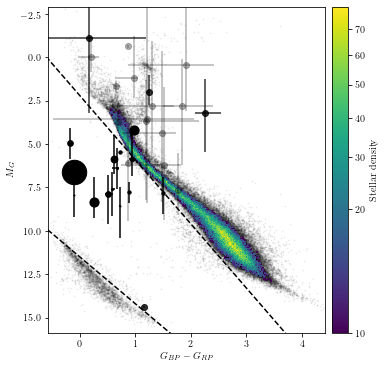

In [81]:
associated = np.where(pulsars['Pass']>=0.9)

def hr_diagram(pulsars,extinction=None):
    _,pbbins = np.histogram(pulsars[pulsars['pb']<2]['pb'],bins=20)
    brs=[]
    magnitudes=[]
    #HR diagram of known stars 
    gaiarec = np.recfromcsv("gaia-hrd-dr2-200pc.csv")
    bp_rp,mg,pmra,pmdec = gaiarec.bp_rp, gaiarec.mg, gaiarec.pmra,gaiarec.pmdec
    plt.rc('text', usetex=True)
    fig, ax = plt.subplots(figsize=(6, 6))
# only show 2D-histogram for bins with more than 10 stars in them
    h = ax.hist2d(bp_rp, mg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
    ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)



    cb = fig.colorbar(h[3], ax=ax, pad=0.02)
    cb.set_label(r"$\mathrm{Stellar~density}$")

    ax.set_xlabel(r'$G_{BP} - G_{RP}$')
    ax.set_ylabel(r'$M_G$')


    color = np.arange(-3.,5.,0.1)
    ax.plot(color,2.7*color+11.5,color='k',ls='--')
    ax.plot(color,3.7*color+2.2,color='k',ls='--')



    if  extinction is None:
        extinction = extinction_to_pulsars(pulsars)
        

    i=0
    j=0
    for pulsar in pulsars:
        distance,_,_,_,_=distance_to_pulsar(pulsar)
        dist_mod = 5*np.log10(1000.*distance)-5.
        try:
            Rv = np.interp(dist_mod,extinction[i]['distmod'],extinction[i]['best'])*3.1
        except:
            if distance[0]<=8.:
                Rv = extinction[i]['EBV_SFD']*3.1*(distance/8.)
            else:
                Rv = extinction[i]['EBV_SFD']*3.1**np.ones_like(distance)
                

        Mg =  pulsar['phot_g_mean_mag'] - dist_mod - Rv
        BR = pulsar['bp_rp'] - Rv/3.1 
        if (pulsar['pb']>0) & (pulsar['pb']<1e20): 

           # if types[j]=='MS':
            if (pulsar['pb']<= 2) & (pulsar['name'] != 'J1435-6100'):
                ax.errorbar(BR[0], 
                            Mg[0], 
                            xerr=np.array([[BR[0]-BR[2] ,BR[1]-BR[0]]]).T,  
                            yerr=np.array([[Mg[0]-Mg[2] ,Mg[1]-Mg[0]]]).T, 
                            fmt='ko',ms=find_nearest(pbbins,pulsar['pb'])*15, alpha=1.0)
            else:
                ax.errorbar(BR[0], 
                            Mg[0], 
                            xerr=np.array([[BR[0]-BR[2] ,BR[1]-BR[0]]]).T,  
                            yerr=np.array([[Mg[0]-Mg[2] ,Mg[1]-Mg[0]]]).T, 
                            fmt='ko', alpha=0.8)
                
            j=j+1
        else:
            ax.errorbar(BR[0], 
                        Mg[0], 
                        xerr=np.array([[BR[0]-BR[2] ,BR[1]-BR[0]]]).T,  
                        yerr=np.array([[Mg[0]-Mg[2] ,Mg[1]-Mg[0]]]).T, 
                        fmt='ko',alpha=0.3)
            j=j+1
        i = i+1
        brs.append(BR[0])
        magnitudes.append(Mg[0])
 #   ax.xlim(-0.5,5)
 #   ax.ylim(18,-7)
    ax.invert_yaxis()
    return brs,magnitudes,extinction


_,_,_=hr_diagram(pulsars[associated])



...and this will make an RPM/color diagram 

/Users/janton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:260: RuntimeWarning: divide by zero encountered in double_scalars
/Users/janton/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


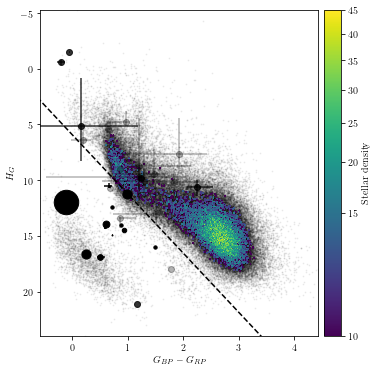

In [82]:
def rpm_diagram(pulsars,extinction=None):

    _,pbbins = np.histogram(pulsars[pulsars['pb']<2]['pb'],bins=20)
    brs=[]
    magnitudes=[]
    if  extinction is None:
        extinction = extinction_to_pulsars(pulsars)
        
    #HR diagram of known stars 
    gaiarec = np.recfromcsv("gaia-hrd-dr2-200pc.csv")
    bp_rp,mg,pmra,pmdec,parallax = gaiarec.bp_rp, gaiarec.mg, gaiarec.pmra,gaiarec.pmdec,gaiarec.parallax
    plt.rc('text', usetex=True)
    fig, ax = plt.subplots(figsize=(6, 6))
    
# only show 2D-histogram for bins with more than 10 stars in them
    mu = (pmra**2 + pmdec**2)**0.5
    hg = mg + 5*np.log10(mu)-5*np.log10(parallax)
    h = ax.hist2d(bp_rp, hg, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
    
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
    ax.scatter(bp_rp,hg , alpha=0.05, s=1, color='k', zorder=0)
    cb = fig.colorbar(h[3], ax=ax, pad=0.02)
    ax.set_xlabel(r'$G_{BP} - G_{RP}$')
    ax.set_ylabel(r'$H_G$')
    cb.set_label(r"$\mathrm{Stellar~density}$")


    color = np.arange(-3.,5.,0.1)
    ax.plot(color,5.3*color+5.9,color='k',ls='--')


    i=0
    j=0
    for pulsar in pulsars:
        distance,_,_,_,_=distance_to_pulsar(pulsar)
            #distance,_,_,_,_=distance_from_px(pulsar['parallax'],pulsar['parallax_error'])
        dist_mod = 5*np.log10(1000.*distance)-5.
        try:
            Rv = np.interp(dist_mod,extinction[i]['distmod'],extinction[i]['best'])*3.1
        except:
            if distance[0]<=8.:
                Rv = extinction[i]['EBV_SFD']*3.1*(distance/8.)
            else:
                Rv = extinction[i]['EBV_SFD']*3.1*np.ones_like(distance)
        
        mu = (pulsar['pmra']**2 + pulsar['pmdec']**2)**0.5
        Mg =  pulsar['phot_g_mean_mag'] + 5*np.log10(mu)-10-Rv
        BR = pulsar['bp_rp'] - Rv/3.1 
        if (pulsar['pb']>0) & (pulsar['pb']<1e20): 

            if (pulsar['pb']<= 2) & (pulsar['name'] != 'J1435-6100'):
                ax.errorbar(BR[0], 
                            Mg[0], 
                            xerr=np.array([[BR[0]-BR[2] ,BR[1]-BR[0]]]).T,  
                            yerr=np.array([[Mg[0]-Mg[2] ,Mg[1]-Mg[0]]]).T, 
                            fmt='ko',ms=find_nearest(pbbins,pulsar['pb'])*15, alpha=1.0)

            else:
                ax.errorbar(BR[0], 
                            Mg[0], 
                            xerr=np.array([[BR[0]-BR[2] ,BR[1]-BR[0]]]).T,  
                            yerr=np.array([[Mg[0]-Mg[2] ,Mg[1]-Mg[0]]]).T, 
                            fmt='ko', alpha=0.8)
            
            j=j+1
        else:
            plt.errorbar(BR[0], 
                         Mg[0], 
                         xerr=np.array([[BR[0]-BR[2] ,BR[1]-BR[0]]]).T,  
                         yerr=np.array([[Mg[0]-Mg[2] ,Mg[1]-Mg[0]]]).T, 
                         fmt='ko',
                         alpha=0.3)
            j=j+1
        brs.append(BR[0])
        magnitudes.append(Mg[0])
        i = i+1
 #   ax.xlim(-0.5,5)
 #   ax.ylim(18,-7)
    ax.invert_yaxis()
    return brs,magnitudes,extinction

_,_,_=rpm_diagram(pulsars[associated],extinction=None)

In [ ]:
def query_pulsar_candidates(query_size=100000, distance=4000, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """

    job = Gaia.launch_job_async("select top {}".format(query_size)+
                " lum_val, teff_val,"
                " ra, dec, parallax,"
                " pmra, pmdec, phot_g_mean_mag,"
                " bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg,"
                " phot_g_mean_mag+5*log10(sqrt(power(pmra,2) + power(pmdec,2)))-10 as rpm"
         " from gaiadr2.gaia_source"
         " where parallax_over_error > 3"
         " and visibility_periods_used > 4"
         " and phot_g_mean_mag+5*log10(sqrt(power(pmra,2) + power(pmdec,2)))-10 > 5.3*(bp_rp)+5.9"
         " and phot_g_mean_mag+5*log10(parallax)-10 <2.7*(bp_rp)+11.5"
         " and phot_g_mean_mag+5*log10(parallax)-10 > 3.7*(bp_rp)+2.2"
         +" and 1000/parallax <= {}".format(distance), **kwargs)

    return job

job = query_pulsar_candidates(dump_to_file=True, output_format="csv",
                                 output_file="pulsar_candidates_4kpc.csv")
r = job.get_results()

In [103]:
colors = r['bp_rp']
rpm = r['rpm']

#Note that the maximum search radius allowed in XMAtch is 180 arcsec. 
#This is suboptimal, given the typical size of Fermi error boxes is ~10-20 arcmin 
candidate_cross_matches = XMatch.query(
        cat1=open('pulsar_candidates_4kpc.csv'),
        cat2='vizier:J/ApJS/247/33/4fgl', max_distance=60*u.arcsec, 
        colRA1='ra', colDec1='dec',colRA2='ra_epoch2000',colDec2='dec_epoch2000') 

In [102]:
candidate_cross_matches

angDist,lum_val,teff_val,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,mg,rpm,_RAJ2000,_DEJ2000,4FGL,RAJ2000,DEJ2000,amaj95,bmin95,PA95,Sig,F1000i,e_F1000i,EF100,e_EF100,Mod,PLGam,F50,F100,F300,F1000,F3000,F10000,F30000,VarInd,FGL,Cl1,Assoc1,Flags,LC
float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,str17,str3,str21,int64,str2
19.996127,--,--,106.43938749444523,-48.80500783224517,4.184878290533476,0.9694281993442715,22.009838326372048,20.80896,2.1894894,13.917374120232239,17.52414849088564,106.4472,-48.8071,J0705.7-4848,106.4472,-48.8071,0.0406,0.0378,32.89,13.92355,6.20959e-10,5.99285e-11,7.69547e-12,7.38919e-13,PowerLaw,2.32776,5.84071e-09,7.03455e-09,2.9339e-09,5.17917e-10,1.08514e-10,1.9499e-11,3.3929e-16,11.331958,3FGL J0706.1-4849,bcu,PMN J0705-4847,0,LC
42.59157,--,--,60.24453343251878,-53.899626145754226,3.2899011608918203,0.2951223079200358,4.073043809427242,20.788757,0.98174095,13.374671577001937,13.844038021760785,60.2646,-53.8992,J0401.0-5353,60.2646,-53.8992,0.0541,0.0482,25.74,7.39093,8.89987e-11,2.63703e-11,1.41238e-12,3.61466e-13,PowerLaw,1.563264,1.13254e-12,2.62949e-09,5.46737e-11,4.32496e-11,1.55149e-11,1.81389e-11,1.24646e-11,8.727586,3FGL J0401.0-5359,bcu,1RXS J040111.9-535456,0,LC
32.501173,--,--,272.0951776409979,-33.988866176475284,0.8052674229257246,-3.289361445812635,-4.593975457154795,18.2781,1.0785122,7.807799710433372,12.038409633921887,272.1018,-33.9817,J1808.4-3358,272.1018,-33.9817,0.0491,0.0422,46.19,16.12056,1.59666e-09,1.22575e-10,7.82973e-12,7.95087e-13,LogParabola,2.434298,3.87327e-13,3.73013e-09,2.7388e-09,1.39159e-09,1.15313e-10,4.23312e-18,3.46431e-15,2.388958,3FGL J1808.3-3357,--,--,0,LC
48.563764,--,--,239.70617891750464,56.43863122638315,0.4484018396056932,-3.4704185087026937,-3.600750450526488,18.59229,1.1517124,6.850627806574298,12.08754074348461,239.7179,56.4268,J1558.8+5625,239.7179,56.4268,0.023,0.0215,74.16,32.8505,1.00124e-09,5.33844e-11,1.11742e-11,5.7691e-13,PowerLaw,2.116009,4.16181e-11,1.14693e-08,2.57149e-09,7.19984e-10,2.68298e-10,6.06555e-11,3.92572e-15,52.568493,3FGL J1558.9+5625,bll,TXS 1557+565,512,LC
2.858614,--,--,333.903074821704,51.587543815812424,0.970766105261058,-2.7766721379394235,-4.181322503792148,18.937775,1.0441608,8.873347679881949,12.440990149987961,333.9018,51.5876,J2215.6+5135,333.9018,51.5876,0.0198,0.0192,86.66,36.36046,2.41027e-09,1.04943e-10,1.7168e-11,8.1165e-13,PLSuperExpCutoff,2.220485,2.20945e-08,9.56233e-09,5.22234e-09,1.97956e-09,4.52221e-10,3.34346e-11,2.49818e-12,8.75527,3FGL J2215.6+5134,PSR,PSR J2215+5135,0,LC
20.962434,--,--,314.1224337342476,31.70727451505567,0.45127605433993334,-3.9517026158226956,-8.226776448272396,18.177896,0.8818321,6.450107947381465,12.979454314736472,314.1198,31.7019,J2056.4+3142,314.1198,31.7019,0.0489,0.0475,87.1,17.96861,1.48422e-09,1.12494e-10,1.06465e-11,1.01364e-12,LogParabola,2.406558,3.64811e-09,6.30143e-09,5.40391e-09,1.22376e-09,1.42526e-10,3.89552e-12,2.82681e-18,6.767795,--,--,--,4,LC
48.906652,--,--,359.5075275779497,68.66803787992434,2.3304668377529643,-8.547882409354203,4.607692298860934,20.662437,1.5395126,12.499652075751193,15.598683534107082,359.4745,68.6617,J2357.8+6839,359.4745,68.6617,0.089,0.0774,8.77,5.1143,3.59822e-10,6.8878e-11,5.46846e-12,1.41887e-12,PowerLaw,2.525859,1.3657e-10,9.20391e-09,2.24832e-09,2.48681e-10,5.78916e-11,8.46175e-12,1.01048e-14,4.999248,--,--,--,0,LC
4.930713,--,--,196.00470858559925,-55.65013462245615,0.9246317672438251,-6.981030652210412,0.1581790832690951,19.069069,1.3529015,8.898912959986372,13.289223911188657,196.0049,-55.6515,J1304.0-5539,196.0049,-55.6515,0.1039,0.0743,4.03,5.16685,2.95279e-10,6.359e-11,5.621e-12,1.35287e-12,PowerLaw,2.689312,6.98945e-08,1.03689e-08,2.32227e-09,1.45728e-10,5.01065e-11,3.86509e-14,5.061e-12,12.513888,3FGL J